# Amplitude Amplification Procedure

As explained before, main objective of present library is use quantum algorithms for computing the expected value of a function $f(x)$ when the $x$ variable follows a probability distribution $p(x)$: $E_{x\sim p}(f)$. This is computed as:

$$E_{x\sim p}(f)=\int_a^bp(x)f(x)dx$$

In notebook **01_DataLoading_Module_Use** mandatory steps for loading probability $p(x)$ and $f(x)$ using operators $\mathcal{P}$ and  $\mathcal{F}$ were reviewed.

In notebook **02_AmplitudeAmplification_Operators** the use of this $\mathcal{P}$ and  $\mathcal{F}$ for creating the correspondient Grover-like operator $\mathcal{Q}$ was presented.

Present notebook explain how to use $\mathcal{Q}$ for computing the desired $E_{x\sim p}(f)$ and the problems that arise will be analysed

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
%load_ext qat.core.magic

The qat.core.magic extension is already loaded. To reload it, use:
  %reload_ext qat.core.magic


In [4]:
global_qlmaas = True
try:
    from qlmaas.qpus import LinAlg
except (ImportError, OSError) as e:
    global_qlmaas = False
from qat.qpus import PyLinalg

In [5]:
def get_qpu(qlmass=False):
    """
    Function for selecting solver. User can chose between:
    * LinAlg: for submitting jobs to a QLM server
    * PyLinalg: for simulating jobs using myqlm lineal algebra.

    Parameters
    ----------

    qlmass : bool
        If True  try to use QLM as a Service connection to CESGA QLM
        If False PyLinalg simulator will be used

    Returns
    ----------
    
    lineal_qpu : solver for quantum jobs
    """
    if qlmass:
        if global_qlmaas:
            print('Using: LinAlg')
            linalg_qpu = LinAlg()
        else:
            raise ImportError("""Problem Using QLMaaS.Please create config file or use mylm solver""")
            
    else:
        print('Using PyLinalg')
        linalg_qpu = PyLinalg()
    return linalg_qpu

In [6]:
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg
QLMaaS = True
linalg_qpu = get_qpu(QLMaaS)

Using: LinAlg


In [7]:
sys.path.append("../../")

## 1. Data Discretization

As usual we begin by discretizing $p(x)$ and function $f(x)$ needed for calculating expected value $E_{x\sim p}(f)$

In [8]:
from my_lib.utils import  get_histogram, run_job, postprocess_results
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [9]:
#number of Qbits for the circuit
n_qbits = 4
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

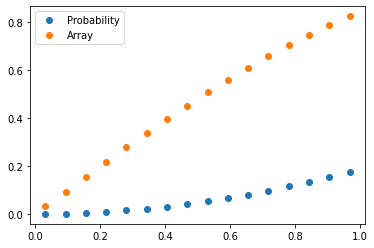

In [10]:
%matplotlib inline
plt.plot(X, p_X, 'o')
plt.plot(X, f_X, 'o')
plt.legend(['Probability', 'Array'])

## 2. $\theta$ estimation problem

After the loading steps our quantum state is: 

$$|\Psi\rangle=\sin{\theta}|\Psi_{1}\rangle+\cos{\theta}|\Psi_{0}\rangle$$

The amplitude of the $|\Psi_{0}\rangle$ state is related with $E_{x\sim p}(f)$ by:

$$\cos \theta = \sqrt{\sum_{x=0}^{2^-1} p(x)f(x)}$$

The main idea in the amplitude amplification is use a similar procedure like in Groover algorithm in order to increase the probability of the $|\Psi_{0}\rangle$ state. This can be in a straightoforward way by applying operator $\mathcal{Q}$ $k$ times:

$$\hat{Q}^{k}|\Psi\rangle = \sin{((2*k+1)\theta)}|\Psi_{1}\rangle+\cos{((2*k+1)\theta})|\Psi_{0}\rangle$$

The idea is apply $k$ in such a way that the probability of $|\Psi_{0}\rangle$ is maximized. For this we can equal:


$$P_{|\Psi_{1}\rangle} = \cos^{2}((2*k+1)\theta) \approx 1$$ 

So:

$$(2k+1)\theta = m\pi$$ where $m=0, 1, 2...$


We have two unknows variables: $\theta$ and $K$. If we know $\theta$ we can know how many applications of $\hat{Q}$ we need for maximazing the state we want.

Other approximation is following one: 

we can prepare the system $n$ times (each time with the same $k$), measure the final state and get the probabilities for measuring  $|\Psi_{1}\rangle$ and $|\Psi_{0}$:

* $P_{|\Psi_{1}\rangle}$: Probability of get state $|\Psi_{1}\rangle$ (we desire a low probability here)
* $P_{|\Psi_{0}\rangle}$: Probability of get state $|\Psi_{0}\rangle$ (we desire a high probability here)

We know that this proabilities are related withe the corresponding amplitudes so: 

$$\cos^{2}((2*K+1)\theta) = P_{|\Psi_{0}\rangle}$$
$$\cos((2*K+1)\theta) = \sqrt{P_{|\Psi_{0}\rangle}}$$
$$(2*K+1)\theta = \arccos{\sqrt{P_{|\Psi_{0}\rangle}}}$$

So in this moment, theoretically, we have solved the problem because we can calculate $\theta$ and the desired $E_{x\sim p}(f)$. But we have a practical important problem: **arccos** is a multivaluated function and usually software packages give a solution in the $[0, \pi]$. If the rotation resulting of apply $\hat{Q}^{K}$ is bigger than $\pi$ then we cannot compute properly $(2*K+1)\theta$.

This can be seen in the following cells

In [11]:
#First create loading operators
from my_lib.data_loading import load_probability, load_array, load_pf
p_gate = load_probability(p_X)
f_gate = load_array(np.sqrt(f_X))
pf_gate = load_pf(p_gate, f_gate)

In [12]:
#Second create the correspondient Grover-like operator
from my_lib.amplitude_amplification import load_q_gate, load_qn_gate
q_gate = load_q_gate(pf_gate)

In [13]:
#Number of times operator Grover-like Q will be applied
k=2
q_k_gate = load_qn_gate(q_gate, 2)

In [16]:
from my_lib.data_extracting import create_qprogram, get_results

In [17]:
#Cration of quantum program for loading data
q_prog = create_qprogram(pf_gate)
registers = q_prog.registers
#Apply Grover^k
q_prog.apply(q_k_gate, registers)

In [18]:
#For getting the state of the additional qbit where the desired integral are stored
Q_k_Phi_State, circuit, q_p, job = get_results(q_prog, linalg_qpu=linalg_qpu, shots=0, qubits=[pf_gate.arity-1])

Submitted a new batch: Job6372


In [19]:
%qatdisplay circuit --depth 0

In [ ]:
Q_k_Phi_State

Now we calculate:  
$$\theta = \frac{\arccos{\sqrt{P_{|\Psi_{0}\rangle}}}}{(2*K+1)}$$

In [ ]:
#This is the angle asociated to the Phi state
theta_K = np.arccos((Q_k_Phi_State['Probability'].iloc[0])**0.5)
print('theta_K: {}'.format(theta_K))
thetaFromK = theta_K/(2*k+1)
print('thetaFromK: {}'.format(thetaFromK))

Additionally in this case we know the true value of $\theta$:

$$ \theta_{th} = \arccos{\sqrt{\sum_{x=0}^{2^-1} p(x)f(x)}}$$

This is done in following cell

In [ ]:
#True value of Theta calculated using the input arrays
theoric_theta = np.arccos(np.sqrt(sum(p_X*f_X)))
print('theoric_theta: {}'.format(theoric_theta))

print('thetaFromK == theoric_theta? {}'.format(np.isclose(thetaFromK, theoric_theta)))

As can be seen in before cell the calculated $\theta$ is different from $\theta_{th}$. But we can compute the probability associated with this $\theta_{th}$ using:

$$\cos^2((2*K+1)\theta_{th}$$

In [ ]:
print('|Psi_0> from  theoric_theta: {}'.format(np.cos((2*k+1)*theoric_theta)**2))
print('|Psi_0> from  Q^KPhi Probability: {}'.format(Q_k_Phi_State['Probability'].iloc[0]))
print('Probability from Q^Phi and from theoric_theta are the same? {}'.format(
    np.isclose(np.cos((2*k+1)*theoric_theta)**2, Q_k_Phi_State['Probability'].iloc[0])

))

So probabilities from $\mathcal{Q}^{K}|\Psi\rangle$ and from $\theta_{th}$ are the same but we cannot calculates the correct angle from the first because of multivalued $\arccos$

## 3. Quantum Fourier Transformation

In order to solve the before section problem we can use the **Phase Estimation Algorithm**. 

Our operator $\hat{Q}$ applies a rotation of an angle $\theta$ on the state $|\Psi\rangle$. This operator is unitary and have 2 eigenvalues in form of phases: $\lambda_{\pm}=e^{\pm i2\theta}$. The **Phase Estimation Algorithm** allow us get this phase $\theta$.

For this we need to create n auxiliary qbits in state $|+\rangle$. Each qbit will be the controlled qbit for a controlled application of $\mathcal{Q}^{K}$ (for each controlled qbit the K will change). Finally over the auxiliary qbits we apply an inverse of the Quantum Fourier Operator ($\mathcal{QFT}$). The measurmente of this auxiliary qbits will give us an estimation of the desired $\theta$. This estimation will be more exact when more auxiliary qbits we use for the $\mathcal{QFT}$.

For this algorithm if we have $m$ auxiliary qbits and the measurment of the $\mathcal{QFT}$ is the integer $M$ then:

$$\theta = \frac{M\pi}{2^m}$$


In [14]:
import qat.lang.AQASM as qlm
#from qat.lang.AQASM.qftarith import QFT

In [32]:
#Allocating Auxiliar qbits for Phase Estimation
n_aux =8

#Cration of quantum program for loading data
q_prog = create_qprogram(pf_gate)
qbits = q_prog.registers[0]
qAux = q_prog.qalloc(n_aux)
#Creating auxiliary qbits for QPE with QFT
for i, aux in enumerate(qAux):
    q_prog.apply(qlm.H, aux)
    step_q_gate = load_qn_gate(q_gate, 2**i)
    q_prog.apply(step_q_gate.ctrl(), aux, qbits)
#Inverse of the Quantum Fourier Transformation        
q_prog.apply(qlm.qftarith.QFT(n_aux).dag(), qAux)


With the function *get_results* from **data_extracting** we can obtain the final, results and the circuit of the created **q_prog**

In [33]:
%%time
Phi, circuit, q_prog, job = get_results(q_prog, linalg_qpu=linalg_qpu, shots=0, qubits=[qAux])

Submitted a new batch: Job6377
CPU times: user 484 ms, sys: 13.5 ms, total: 497 ms
Wall time: 6.38 s


In [34]:
%qatdisplay circuit --depth 0

In [35]:
len(Phi)

256

In [36]:
Phi['Thetas'] = Phi['Int']*np.pi/(2**n_aux)
Phi.sort_values('Probability', ascending=False, inplace = True)

Now in Phi we have a complete pandas DataFrame with the posible results of the circuit:

In [37]:
Phi.head()

,Probability,States,Amplitude,Int,Int_lsb,Thetas
206,0.491042,|11001110>,None,206,115,2.528000
50,0.491042,|00110010>,None,50,76,0.613592
49,0.003142,|00110001>,None,49,140,0.601320
207,0.003142,|11001111>,None,207,243,2.540272
51,0.002335,|00110011>,None,51,204,0.625864


We can plot the probabilities for each posible $\theta$ and we have to obtain 2 máximums of probability around the two atuovalues of $\hat{Q}$: $\pm \theta$

Text(0, 0.5, 'Probability')

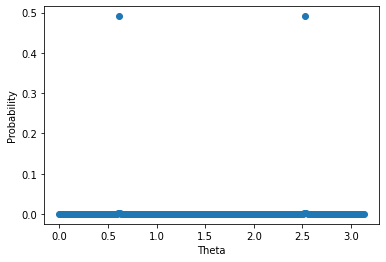

In [38]:
#Now we can plot te probability for each posible theta
%matplotlib inline
plt.plot(Phi['Thetas'], Phi['Probability'], 'o')
plt.xlabel('Theta')
plt.ylabel('Probability')

As can be seen there are two maximum of probabilities at: $\theta_0$ and $\theta_1$ and is mandatory that $\theta_1 = -\theta_0$.

Remenbering that $-\theta = \pi - \theta$ the we can test that the two maximum correspond to $\pm \theta$:

In [39]:
#We take the thetas were probability is maximum
theta_0 = Phi.sort_values('Probability', ascending =False)['Thetas'].iloc[0]
theta_1 = Phi.sort_values('Probability', ascending =False)['Thetas'].iloc[1]

print('theta_0: {}'.format(theta_0))
print('theta_1: {}'.format(theta_1))

theta_0: 2.5280003384355365
theta_1: 0.6135923151542565


In [40]:
#So we test that the 2 are the same angle with different signs
np.isclose(theta_0, np.pi -theta_1)

True

Aditionally we can compute the Expected value as 
$$E_{x\sim p}(f) = \sum_{x=0}^{2^-1} p(x)f(x) = \cos^{2} \theta $$

We can plot the posible expected values versus the probability

Text(0, 0.5, 'Probability')

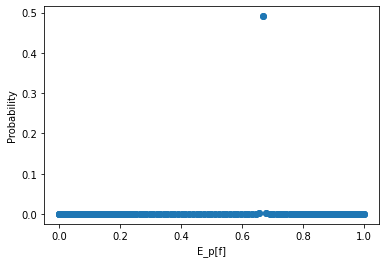

In [41]:
#Now we can plot te probability for each posible theta
%matplotlib inline
plt.plot(np.cos(Phi['Thetas'])**2, Phi['Probability'], 'o')
plt.xlabel('E_p[f]')
plt.ylabel('Probability')

In [42]:
theoric_theta = np.arccos(np.sqrt(sum(p_X*f_X)))
print('theoric_theta: {}'.format(theoric_theta))
print('theta_1: {}'.format(theta_0))
print('Theorical Integration: {}'.format(sum(p_X*f_X)))
print('Amplitude Amplification Integral: {}'.format(np.cos(theta_0)**2))

theoric_theta: 0.6126834259499072
theta_1: 2.5280003384355365
Theorical Integration: 0.6693004071633366
Amplitude Amplification Integral: 0.6684449266961099
